# Foundation+YSE z-band Stretch-Luminosity Relation Analysis

In this notebook, we re-create the sample and figures from the z-band stretch-luminosity relation analysis in Hayes+2024. If you find this resource or the associated paper useful for your work, please cite: .

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at
import corner

from py import utils

plt.style.use('./stylesheet/zband.mplstyle')

In [2]:
# Read data table and apply default cuts, as specified in Hayes+24
full_data = at.Table.read('../tables/full.csv', format='csv')
sample = utils.apply_data_cuts(full_data, print_summary=True)

sample['SIGMA_Z'][sample['SIGMA_Z'] < 0.] = 0.01         # Set the uncertainty on redshifts derived from SN spectra to 0.01

Total Spec Sample:               517 (YSE: 292, Foundation: 225)
Normal Ias:                      446 (YSE: 266, Foundation: 180)
0.015 < z < 0.1:                 344 (YSE: 182, Foundation: 162)
(z < 0.08 for Foundation)
gri Data Requirement:            229 (YSE: 114, Foundation: 115)
z-band Data Requirement:         168 (YSE: 54, Foundation: 114)
Reduced Chi Squared < 3:         162 (YSE: 51, Foundation: 111)
T0 Cut:                          145 (YSE: 40, Foundation: 105)
Av < 1:                          145 (YSE: 40, Foundation: 105)
-1.5 < theta < 3:                144 (YSE: 39, Foundation: 105)
Host Mass Estimate:              141 (YSE: 37, Foundation: 104)

Final Sample:                    141 (YSE: 37, Foundation: 104)
* For complete description of the default data cuts, see Hayes+2024.


## Intrinsic Absolute Magnitude of SNe Ia in the z-band

We will load in the peak magnitudes which have already been extracted from the fiducial fits in Hayes+24. As it is time intensive to extract the peak magnitudes from the BayeSN fits, we have pre-computed the peak magnitudes for all the objects in the sample in all of the griz filters based on the single filter fit. For more details on how this is done, please see Hayes+24, or reach out to Erin Hayes at eeh55@cam.ac.uk.

In [3]:
# Load in the peak magnitudes from the single filter fits (Av=0, corrected for dust with Av from griz fit) from Hayes+24
peak_mags_table = at.Table.read('../tables/peak_mags_table.csv', format='csv')
peak_mags_table = peak_mags_table[np.isin(peak_mags_table['SNID'], sample['SNID'])]
peak_mags_table.sort('SNID')
sample.sort('SNID')

In [4]:
# Get the model distance moduli based on the fiducial cosmology
H0 = 73.24  # km/s/Mpc
Omega_m = 0.28
redshift_final, mu_LCDM = utils.model_for_plotting(sample['REDSHIFT_FINAL'], H0=H0, Omega_m=Omega_m)

# Compute the uncertainty due to peculiar velocities 
sigma_pec = 150 # km/s
sigma = utils.get_peculiar_velocity_unc(redshift_final, sigma_z=sample['SIGMA_Z'], sigma_pec=sigma_pec)

y = peak_mags_table['PEAKMAG_Z_DUSTCORR'] - mu_LCDM                         # Our y-values are the peak intrinsic z-band absolute magnitudes.
yerr = np.sqrt(peak_mags_table['PEAKMAG_Z_DUSTCORR_ERR']**2 + sigma**2)     # Our y-errors include contributions from the fit and PV uncertainty.
                                                                            # The sampler will add in quadrature the scatter term
                                                                            # when fitting for this parameter.

In [5]:
# Run the mass step sampler, implemented in Numpyro
# You can adjust the sampler kwargs (see https://num.pyro.ai/en/stable/mcmc.html for more information) with the hmc_kwargs parameter
sampler = utils.compute_intrinsic_abs_magnitude(y, yerr, hmc_kwargs={'num_chains': 1})
samples_dict = {'M_0_z_int': sampler.get_samples()['M_0_int'], 'sigma_res': np.sqrt(sampler.get_samples()['sigma_2_res'])}

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


sample: 100%|██████████| 14000/14000 [00:02<00:00, 5363.67it/s, 7 steps of size 6.79e-01. acc. prob=0.95]


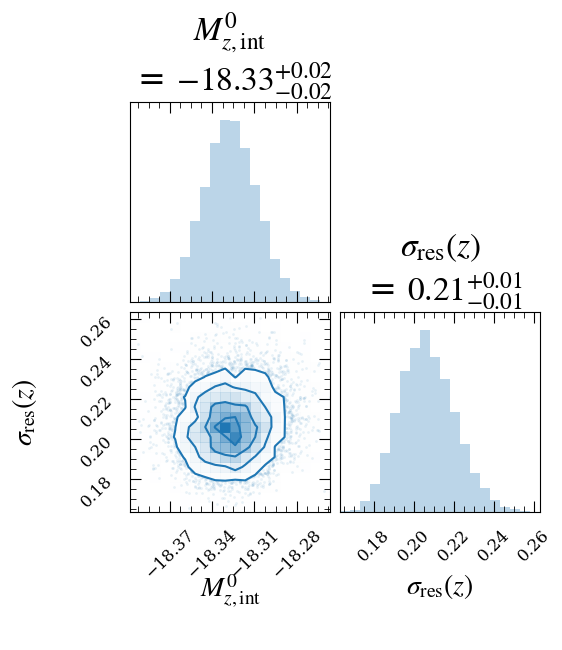

In [6]:
# Show the corner plot for the mass step parameters
fig = corner.corner(samples_dict, color='tab:blue', show_titles=True, hist_kwargs={'histtype': 'stepfilled', 'color': 'tab:blue', 'alpha': 0.3},
                    labels=['$M^{0}_{z, \\rm{int}}$\n', '$\\sigma_{\\rm{res}}(z)$\n'], label_kwargs={'fontsize': 20})

### Comparison to Optical Wavelength Filters

sample: 100%|██████████| 14000/14000 [00:02<00:00, 5479.57it/s, 3 steps of size 9.30e-01. acc. prob=0.90]


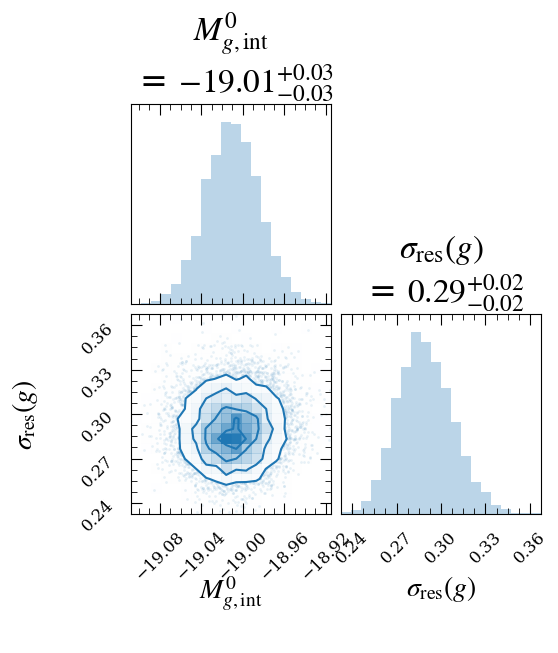

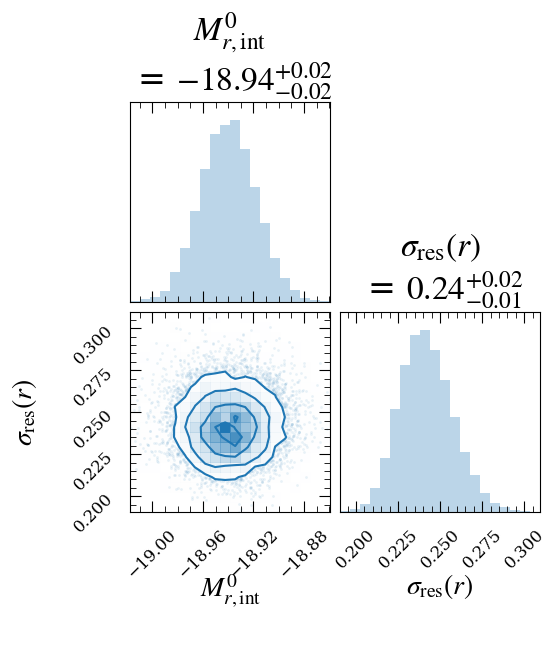

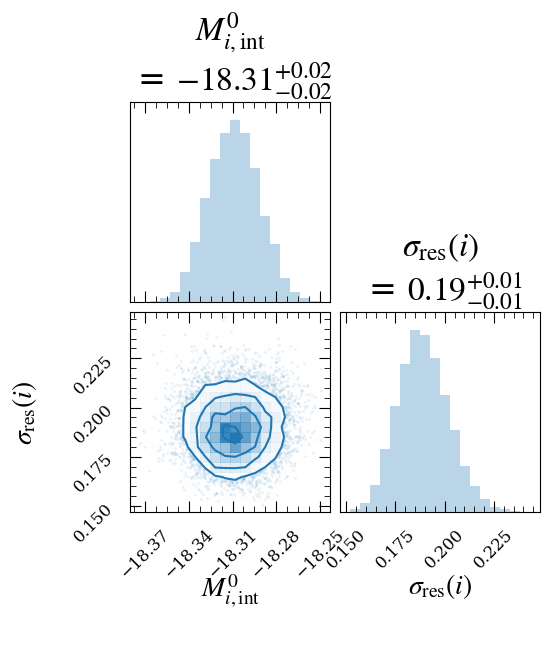

In [7]:
for flt in ['G', 'R', 'I']:
    y = peak_mags_table['PEAKMAG_'+flt+'_DUSTCORR'] - mu_LCDM
    yerr = np.sqrt(peak_mags_table['PEAKMAG_'+flt+'_DUSTCORR_ERR']**2 + sigma**2)

    sampler = utils.compute_intrinsic_abs_magnitude(y, yerr)
    samples_dict = {'M_0_'+flt.lower()+'_int': sampler.get_samples()['M_0_int'],
                    'sigma_res_0': np.sqrt(sampler.get_samples()['sigma_2_res'])}

    fig = corner.corner(samples_dict, color='tab:blue', show_titles=True, hist_kwargs={'histtype': 'stepfilled', 'color': 'tab:blue', 'alpha': 0.3},
                        labels=['$M^{0}_{'+flt.lower()+', \\rm{int}}$\n', '$\\sigma_{\\rm{res}}('+flt.lower()+')$\n'], label_kwargs={'fontsize': 20})

## Stretch-Luminosity Relation

We will re-create Figure 5 from Hayes+24.

In [8]:
x = sample['GRI_THETA']                                                    # The stretch parameter from the fit to the optical data.
xerr = sample['GRI_THETA_ERR']                                             # The uncertainty on the stretch parameter.
y = peak_mags_table['PEAKMAG_Z_DUSTCORR'] - mu_LCDM                        # The peak intrinsic (dust-corrected) absolute z-band magnitude.
yerr = np.sqrt(peak_mags_table['PEAKMAG_Z_DUSTCORR_ERR']**2 + sigma**2)    # Our y-errors include contributions from the fit & PV uncertainty.
                                                                           # The sampler will add in quadrature the scatter term
                                                                           # when fitting for this parameter.

# Run the linear regression model for the stretch-luminosity relation, implemented in Numpyro
sampler = utils.compute_stretch_lum_relation(x, xerr, y, yerr)
samples = sampler.get_samples()
samples_dict = {'a': samples['a'], 'b': samples['b'], 'sigma_res': np.sqrt(samples['sigma_2_res'])}

sample: 100%|██████████| 14000/14000 [00:11<00:00, 1212.61it/s, 7 steps of size 4.58e-01. acc. prob=0.82]


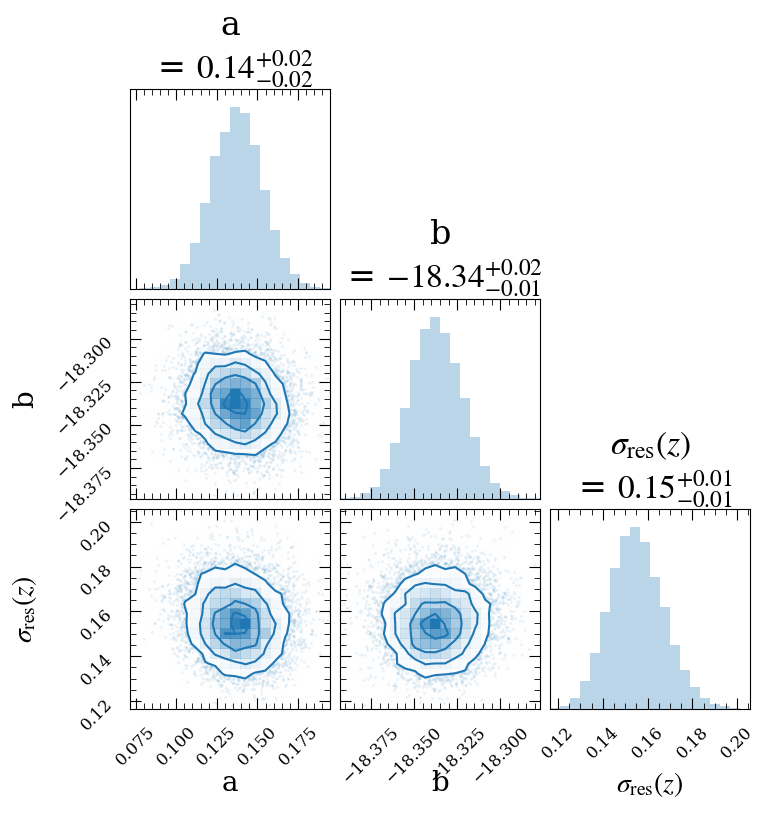

In [9]:
# Plot the corner plot for the slope, a, the y-intercept, b, and the residual scatter term, sigma^2_{res, theta}
fig = corner.corner(samples_dict, color='tab:blue', show_titles=True,
                    hist_kwargs={'histtype': 'stepfilled', 'color': 'tab:blue', 'alpha': 0.3},
                    labels=['a\n', 'b\n', '$\\sigma_{\\rm{res}}(z)$\n'])

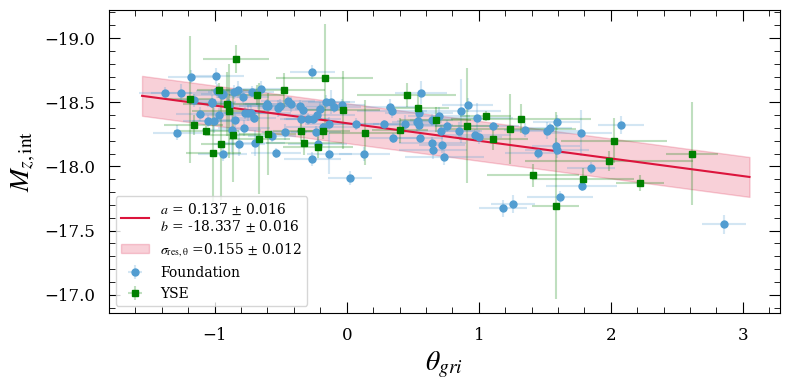

In [10]:
# Plot M_z,int vs theta with the fitted stretch-luminosity relation overplotted, as in Figure 5 from Hayes+24
fig, ax = utils.plot_stretch_lum_relation(x, xerr, y, yerr, survey_mask=sample['SURVEY'] == 'YSE', samples=sampler.get_samples())